In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math
import bcolz
import pickle
import re

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data loading

In [6]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [7]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [8]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


Note we dropped VERBATIM class. Thats because it had so many weird characters.

In [9]:
all_data_sentence_index = all_data.set_index('sentence_id')

### More balanced sample

In [10]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [11]:
all_data_classes = list(all_data.groupby('class'))

In [12]:
all_data_classes[0][1].sample(2).append(all_data_classes[1][1].sample(2))

,sentence_id,token_id,class,before,after
1181123,93940,23,ADDRESS,C1,c one
3707902,287635,10,ADDRESS,C5,c five
752773,60496,7,CARDINAL,105,one hundred five
3860737,299175,0,CARDINAL,249,two hundred forty nine


In [13]:
data_balanced_classes = pd.concat([v.sample(min(50000, len(v))) for k, v in all_data_classes])

In [14]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      50000
DATE          50000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       50000
MEASURE       14783
MONEY          6128
ORDINAL       12703
PLAIN         50000
PUNCT         50000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [15]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
9661482,734764,5,CARDINAL,99,ninety nine
9114861,693819,13,LETTERS,F.C.,f c
7852067,599754,9,LETTERS,GM,g m
9600089,730199,8,PUNCT,:,:
7957590,607584,16,PLAIN,crescent,crescent
8305615,633668,5,LETTERS,F-,f
657469,52950,10,LETTERS,PDF,p d f
9249671,703817,11,PUNCT,),)
323441,26210,4,LETTERS,IM,i m
7374284,563795,5,PUNCT,:,:


In [16]:
test = data_balanced_classes.sample(10)
test

,sentence_id,token_id,class,before,after
5895462,452974,15,DATE,1947,nineteen forty seven
4418910,341422,6,PLAIN,of,of
3170411,246619,22,PUNCT,!,!
4573971,353183,11,PUNCT,",",","
5191100,399833,2,LETTERS,TV,t v
8318585,634647,7,PLAIN,of,of
5829307,447979,14,ORDINAL,4th,fourth
7317073,559489,7,CARDINAL,24,twenty four
7965491,608177,19,DATE,"July 17, 2004",july seventeenth two thousand four
2506580,196053,1,PLAIN,on,on


In [17]:
data_balanced_classes_matrix = data_balanced_classes.as_matrix()

In [18]:
%%timeit
data_balanced_classes.sample(1)

5.27 ms ± 96.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
data_balanced_classes.iloc[random.randint(1, len(test)-1)]

101 µs ± 934 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
%%timeit
data_balanced_classes_matrix[random.randint(1, len(test)-1)]

2.12 µs ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Word vectors

In [21]:
def load_glove(name):
    with open(name, 'r') as f: lines = [line.split() for line in f]
    words = [d[0] for d in lines]
    vecs = np.stack(np.array(d[1:], dtype=np.float32) for d in lines)
    wordidx = {o:i for i,o in enumerate(words)}
    return vecs, words, wordidx

In [22]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [23]:
wv_max_words = len(wv_words)
print("Original last word:", wv_words[wv_max_words - 1])

Original last word: sandberger


In [24]:
wv_vecs = np.concatenate((wv_vecs, np.zeros([1, 50], dtype=np.float32)), axis=0)
wv_words.append('SAMPLE')
wv_idx['SAMPLE'] = wv_words.index('SAMPLE')

In [25]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_tokeniser(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' - ')
    sent = re_punc.sub(r" \1 ", sent)
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()
simple_tokeniser("asdf's   asdf   -testaaa")

['asdf', "'s", 'asdf', '-', 'testaaa']

In [26]:
arr = [simple_tokeniser(s_)[0] for s_ in list(all_data.sample(1000)['before'])]
[s in wv_idx for s in arr].count(True) / 1000

0.986

In [27]:
def get_random_sample():
    sample_row = data_balanced_classes.iloc[random.randint(1, len(data_balanced_classes)-1)]
    sentence_id = sample_row['class']

    #rows = all_data[all_data['sentence_id']==sample_row['sentence_id']]
    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = '*****'
    str_list = simple_tokeniser(' '.join(befores))
    
    word_vect = np.zeros((1, len(str_list), wv_vecs.shape[1]), dtype=np.float32)
    # var = np.zeros((1, len(str_list), wv_vecs.shape[1]+1))
    for i, w in enumerate(str_list):
        if w=='*****':
            word_vect[0][i] = np.zeros((1, wv_vecs.shape[1]))
        else:
            try:
                word_vect[0][i] = wv_vecs[wv_idx[w]]
            except KeyError:
                word_vect[0][i] = np.random.rand(1, wv_vecs.shape[1])
    return sample_row['before'], sample_row['after'], sample_row['class'], word_vect
            
# get_random_sample()
s_bef, s_aft, s_class, s_word_v = get_random_sample()
print(s_class, ':', s_bef, '->', s_aft, ':', s_word_v.shape, type(s_word_v[0,0,0]))

CARDINAL : 2 -> two : (1, 16, 50) <class 'numpy.float32'>


In [28]:
%%timeit
get_random_sample()

505 µs ± 2.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Categories and Chars

In [29]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'DECIMAL' 'MEASURE' 'MONEY'
 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE' 'ADDRESS']
15


In [30]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [31]:
def string_to_tensor(line):
    tensor = torch.zeros(1, len(line), letters_n)
    for li, letter in enumerate(line):
        tensor[0, li, letters_index[letter]] = 1
    return tensor
print(string_to_tensor('wordup').size())

torch.Size([1, 6, 112])


# Model

In [32]:
use_cuda = False

In [35]:
class RNN_WORDS_CHARS_CLASS(nn.Module):
    def __init__(self, wordvect_size, letters_size, hidden_size, output_size, n_layers=1):
        super(RNN_WORDS_CHARS_CLASS, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_words = nn.LSTM(wordvect_size, hidden_size, n_layers, batch_first=True)

        self.rnn_chars = nn.LSTM(letters_size, hidden_size, n_layers, batch_first=True)
        
        self.lin_1 = nn.Linear(hidden_size*2, 1024)
        self.lin_output = nn.Linear(1024, output_size)

    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var1_2 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var2_1 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        var2_2 = Variable(torch.zeros(1, self.n_layers, self.hidden_size))
        if use_cuda:
            var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
            var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

use_cuda = False
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
s_string = string_to_tensor(s_bef)
model_tmp = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all))
print('Word vect size:', s_word_vs.shape, '. String vector size:', s_string.size())
output = model_tmp(Variable(torch.from_numpy(s_word_vs)), Variable(s_string))
print('Output:', output.size())

Word vect size: (1, 8, 50) . String vector size: torch.Size([1, 1, 112])
Output: torch.Size([1, 15])


In [36]:
use_cuda=True

In [38]:
tmp = use_cuda
use_cuda = True
model_tmp.cuda()
output = model_tmp(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_string).cuda())
use_cuda = tmp
type(output.data)

torch.cuda.FloatTensor

In [39]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(category_from_output(output))

('DIGIT', 11)


### Accuracy

In [40]:
use_cuda = True

In [41]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    n_correct = 0
    for iteration in range(n_sample):
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()
        s_string = Variable(string_to_tensor(s_bef))
        s_word_vs = Variable(torch.from_numpy(s_word_vs))
        if use_cuda:
            s_word_vs = s_word_vs.cuda()
            s_string = s_string.cuda()
        output = model(s_word_vs, s_string)
        if s_class == category_from_output(output)[0]:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

In [43]:
%%time
test_model_accuracy(model_tmp, n_sample=1000)

Accuracy: 4.90% (      49/    1000)
CPU times: user 2.3 s, sys: 40 ms, total: 2.34 s
Wall time: 2.34 s


# Training

In [44]:
def train(model, category, word_vectors, string):
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    word_vectors = Variable(torch.from_numpy(word_vectors))
    string = Variable(string_to_tensor(string))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        word_vectors = word_vectors.cuda()
        string = string.cuda()

    output = model(word_vectors, string)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [161]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
train(model, s_class, s_word_vs, s_bef)

(Variable containing:
 
 Columns 0 to 9 
 -1.7899 -1.5999 -1.7431 -1.7840 -1.8631 -3.8468 -3.2847 -4.5116 -3.4812 -6.1416
 
 Columns 10 to 14 
 -4.6041 -4.5043 -6.4336 -4.9500 -7.5641
 [torch.cuda.FloatTensor of size 1x15 (GPU 0)], 1.7899038791656494)

In [45]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [46]:
def train_iterations(n_iters=100000, start_iter=0, print_every=5000, plot_every=1000):
    model.train()
    start = time.time()
    all_losses = []
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()

        output, loss = train(model, s_class, s_word_vs, s_bef)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == s_class else "✗ ({})".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>6.2f}   | {:>6.2f}: {} -> {} {}".format(
                (iteration+start_iter), iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                s_bef, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            current_loss_iter = 0
    
    test_model_accuracy(model, n_sample=10000)
    return all_losses

In [47]:
model = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all)).cuda()
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=100000, print_every=20000)

 20000  20% (  1m 37s)   0.25   |   0.00: NSO -> LETTERS ✓
 40000  40% (   3m 6s)   0.17   |   0.00: 5 ft -> MEASURE ✓
 60000  60% (  4m 39s)   0.15   |   0.12: 1960s -> DATE ✓
 80000  80% (  6m 18s)   0.15   |   0.02: 1997 -> DATE ✓
100000 100% (  7m 58s)   0.14   |   0.00: like -> PLAIN ✓
Accuracy: 96.61% (    9661/   10000)


In [48]:
all_losses_2 = train_iterations(n_iters=200000, start_iter=100000, print_every=25000)

125000  12% (  1m 53s)   0.13   |   0.04: 520 -> CARDINAL ✓
150000  25% (  3m 57s)   0.13   |   0.00: " -> PUNCT ✓
175000  38% (   6m 3s)   0.09   |   0.00: , -> PUNCT ✓
200000  50% (   8m 8s)   0.11   |   1.70: 3 -> CARDINAL ✗ (DIGIT)
225000  62% ( 10m 11s)   0.14   |   0.00: , -> PUNCT ✓
250000  75% ( 12m 15s)   0.10   |   0.00: systems -> PLAIN ✓
275000  88% ( 14m 22s)   0.11   |   0.00: $5,000 -> MONEY ✓
300000 100% ( 16m 38s)   0.10   |   0.00: Another -> PLAIN ✓
Accuracy: 97.83% (    9783/   10000)


In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=100000, start_iter=300000, print_every=25000)

325000  25% (   2m 0s)   0.07   |   0.00: , -> PUNCT ✓
350000  50% (  3m 54s)   0.07   |   0.00: HJK -> LETTERS ✓
375000  75% (  5m 50s)   0.09   |   0.00: 1883 -> DATE ✓
400000 100% (  7m 49s)   0.05   |   0.00: 1669 -> DATE ✓
Accuracy: 97.86% (    9786/   10000)


In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=100000, start_iter=400000, print_every=25000)

425000  25% (  1m 55s)   0.06   |   0.00: 1996 -> DATE ✓
450000  50% (  3m 50s)   0.05   |   0.00: Nineteenth -> PLAIN ✓
475000  75% (  5m 49s)   0.10   |   0.03: 75 -> CARDINAL ✓
500000 100% (  7m 45s)   0.07   |   0.00: 3.10 -> DECIMAL ✓
Accuracy: 97.78% (    9778/   10000)


In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=100000, start_iter=400000, print_every=25000)

425000  25% (  1m 55s)   0.06   |   0.00: 1996 -> DATE ✓
450000  50% (  3m 50s)   0.05   |   0.00: Nineteenth -> PLAIN ✓
475000  75% (  5m 49s)   0.10   |   0.03: 75 -> CARDINAL ✓
500000 100% (  7m 45s)   0.07   |   0.00: 3.10 -> DECIMAL ✓
Accuracy: 97.78% (    9778/   10000)


In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, print_every=25000)

 25000  12% (   2m 3s)   0.05   |   0.00: 1.166 -> DECIMAL ✓
 50000  25% (  4m 11s)   0.05   |   0.00: 426.3 -> DECIMAL ✓
 75000  38% (  6m 17s)   0.05   |   0.00: always -> PLAIN ✓
100000  50% (  8m 19s)   0.05   |   0.00: March 2015 -> DATE ✓
125000  62% ( 10m 22s)   0.06   |   0.00: and -> PLAIN ✓
150000  75% ( 12m 25s)   0.06   |   0.00: NC -> LETTERS ✓
175000  88% ( 14m 27s)   0.06   |   0.00: 13 March 2012 -> DATE ✓
200000 100% ( 16m 31s)   0.05   |   0.00: 26 March 2007 -> DATE ✓
Accuracy: 98.17% (    9817/   10000)


In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, print_every=50000)

 25000  12% (   2m 2s)   0.04   |   0.00: IDG -> LETTERS ✓
 50000  25% (   4m 4s)   0.04   |   0.00: of -> PLAIN ✓
 75000  38% (   6m 6s)   0.06   |   0.00: The -> PLAIN ✓
100000  50% (   8m 8s)   0.04   |   0.00: 43.404375 -> DECIMAL ✓
125000  62% ( 10m 11s)   0.06   |   0.01: 13 -> CARDINAL ✓
150000  75% ( 12m 14s)   0.06   |   0.00: 1991 -> DATE ✓
175000  88% ( 14m 17s)   0.04   |   0.00: comic -> PLAIN ✓
200000 100% ( 16m 20s)   0.04   |   0.00: July 15, 1944 -> DATE ✓
Accuracy: 98.47% (    9847/   10000)


In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses_2 = train_iterations(n_iters=200000, print_every=50000)

 25000  12% (   2m 2s)   0.05   |   0.00: LP -> LETTERS ✓
 50000  25% (   4m 3s)   0.04   |   0.00: 1 -> CARDINAL ✓
 75000  38% (   6m 5s)   0.05   |   0.00: WRC -> LETTERS ✓
100000  50% (   8m 6s)   0.03   |   0.00: ( -> PUNCT ✓
125000  62% (  10m 7s)   0.04   |   0.00: 1995 -> DATE ✓
150000  75% (  12m 8s)   0.04   |   0.04: 2 -> CARDINAL ✓
175000  88% (  14m 9s)   0.06   |   0.00: 10, 295th -> ORDINAL ✓
200000 100% (  16m 4s)   0.05   |   0.00: Thwack -> PLAIN ✓
Accuracy: 98.33% (    9833/   10000)


### Results eval

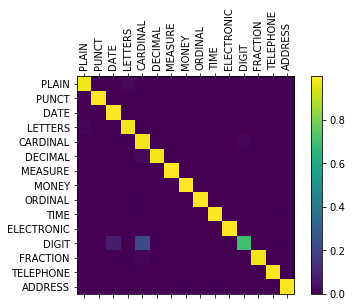

In [55]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    s_bef, s_aft, s_class, s_word_vs = get_random_sample()
    word_vectors = Variable(torch.from_numpy(s_word_vs))
    string = Variable(string_to_tensor(s_bef))
    if use_cuda:
        word_vectors = word_vectors.cuda()
        string = string.cuda()
    output = model(word_vectors, string)
    guess, guess_i = category_from_output(output)
    category_i = categories_index[s_class]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories_all)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

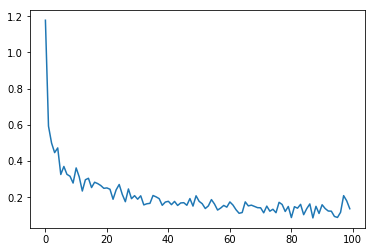

In [60]:
plt.figure()
plt.plot(all_losses)